**Imports and Setup**

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian modeling
import pymc as pm

# For nicer plots
sns.set(style="whitegrid")

**Load and Explore Data**

C:\Users\bezis\AppData\Local\Temp\ipykernel_18072\559541325.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63
                                Date        Price
count                           9011  9011.000000
mean   2005-02-10 23:46:53.760958720    48.420782
min              1987-05-20 00:00:00     9.100000
25%              1996-03-20 12:00:00    19.050000
50%              2005-02-02 00:00:00    38.570000
75%              2014-01-09 12:00:00    70.090000
max              2022-11-14 00:00:00   143.950000
std                              NaN    32.860110


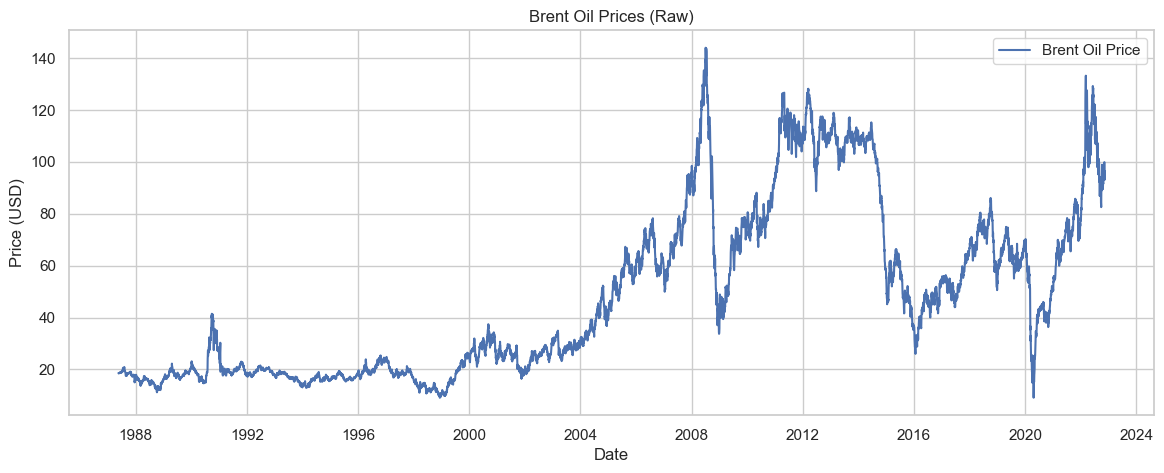

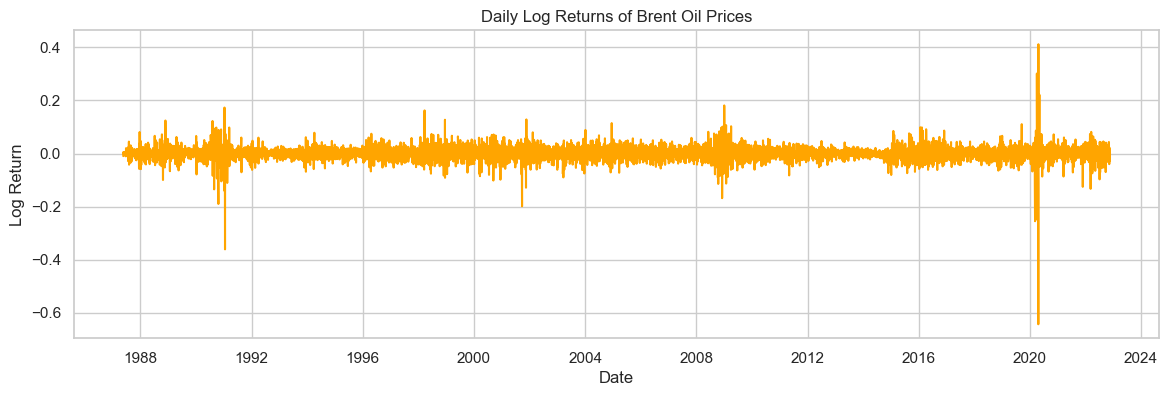

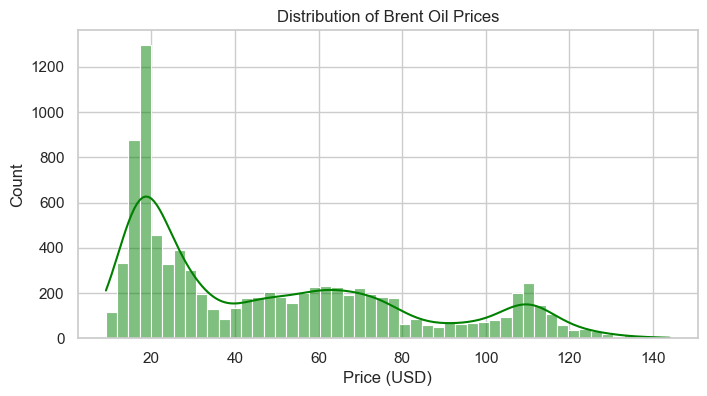

In [3]:
# Load data
data = pd.read_csv(r"C:\Users\bezis\Downloads\Brent-Oil-Insights\data\raw\BrentOilPrices.csv")  # <-- replace with your file
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# Quick look
print(data.head())
print(data.describe())

# Plot raw prices
plt.figure(figsize=(14,5))
plt.plot(data['Date'], data['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices (Raw)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Log returns (for volatility analysis)
data['log_return'] = np.log(data['Price']).diff()
plt.figure(figsize=(14,4))
plt.plot(data['Date'], data['log_return'], color='orange')
plt.title('Daily Log Returns of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# Histogram of prices
plt.figure(figsize=(8,4))
sns.histplot(data['Price'], bins=50, kde=True, color='green')
plt.title('Distribution of Brent Oil Prices')
plt.xlabel('Price (USD)')
plt.show()

**Bayesian Change Point Model**

In [4]:
# Simple one-change-point model
with pm.Model() as model:
    
    # Switch point (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(data)-1)
    
    # Before and after means
    mu1 = pm.Normal("mu1", mu=data['Price'].mean(), sigma=10)
    mu2 = pm.Normal("mu2", mu=data['Price'].mean(), sigma=10)
    
    # Shared sigma
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Mean depending on tau
    mu = pm.math.switch(tau >= np.arange(len(data)), mu1, mu2)
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=data['Price'].values)
    
    # Sample with MCMC
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


**Trace Plots (MCMC Diagnostics)**

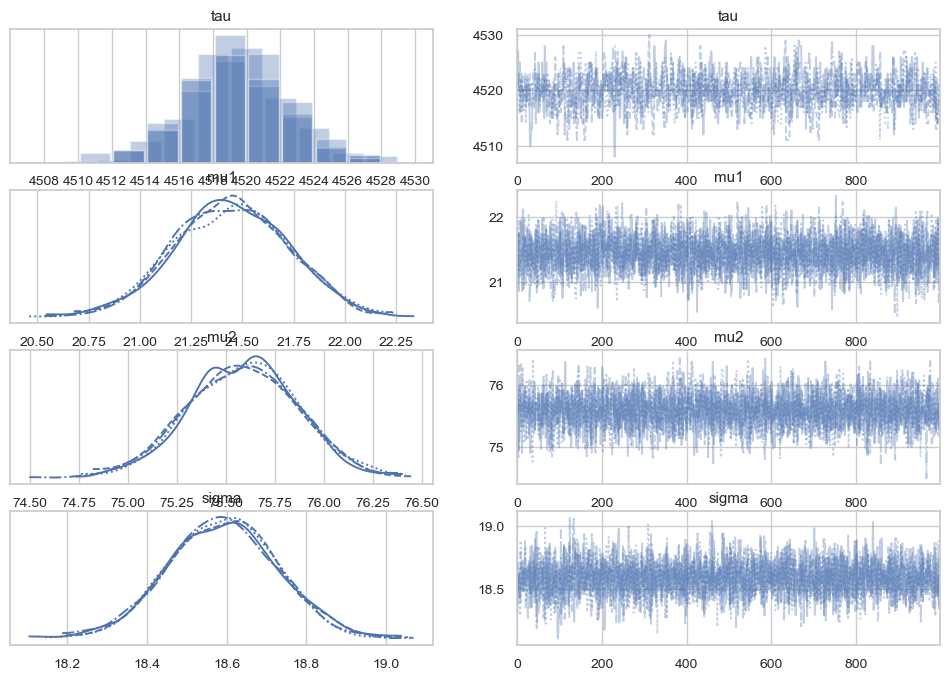

           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    4519.860  3.036  4514.000  4525.000      0.098    0.075     959.0   
mu1      21.446  0.276    20.970    21.996      0.005    0.004    3455.0   
mu2      75.587  0.277    75.059    76.102      0.005    0.005    3563.0   
sigma    18.590  0.135    18.341    18.842      0.002    0.002    3961.0   

       ess_tail  r_hat  
tau       959.0    1.0  
mu1      3015.0    1.0  
mu2      2360.0    1.0  
sigma    2693.0    1.0  


In [5]:
# Trace plots for all parameters
pm.plot_trace(trace)
plt.show()

# Summary table
summary = pm.summary(trace)
print(summary)

**Posterior Distribution of Change Point**

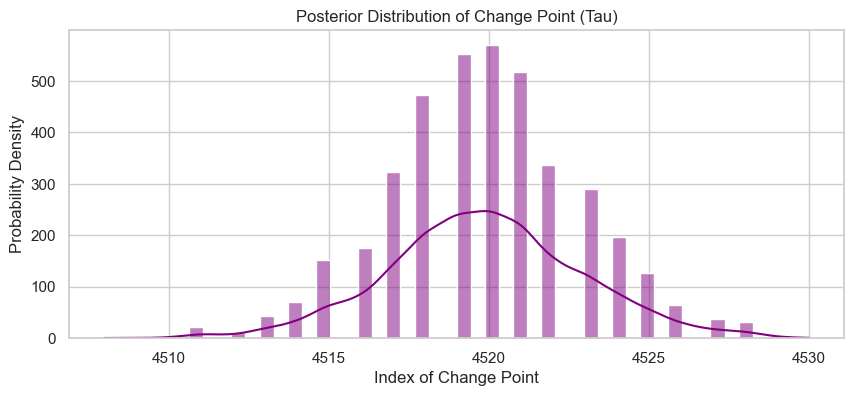

In [6]:
# Posterior distribution of tau
tau_posterior = trace.posterior['tau'].values.flatten()

plt.figure(figsize=(10,4))
sns.histplot(tau_posterior, bins=50, kde=True, color='purple')
plt.title('Posterior Distribution of Change Point (Tau)')
plt.xlabel('Index of Change Point')
plt.ylabel('Probability Density')
plt.show()

**Overlay Change Point on Price Series**

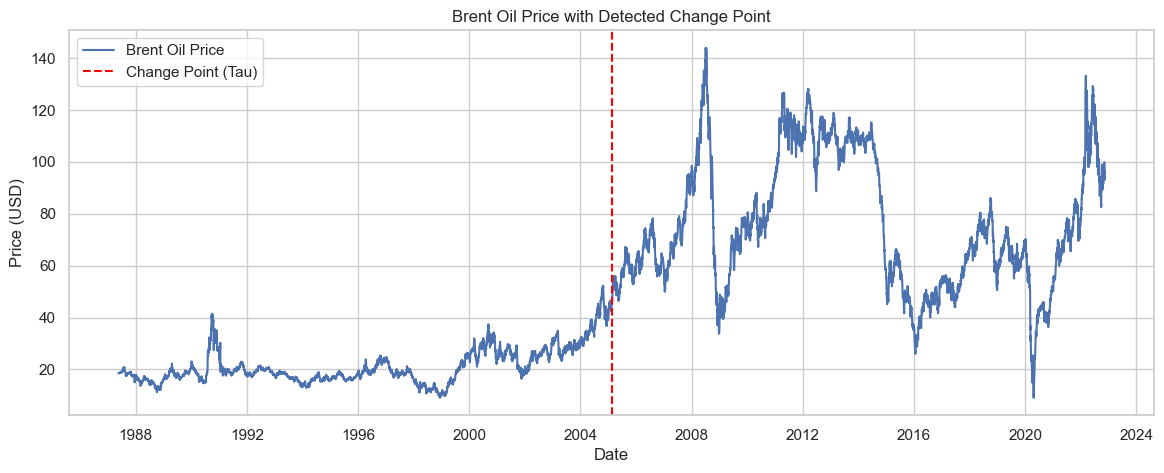

In [7]:
# Mean tau
tau_mean = int(tau_posterior.mean())

plt.figure(figsize=(14,5))
plt.plot(data['Date'], data['Price'], label='Brent Oil Price')
plt.axvline(data['Date'].iloc[tau_mean], color='red', linestyle='--', label='Change Point (Tau)')
plt.title('Brent Oil Price with Detected Change Point')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

**Before & After Price Comparison**

Estimated Change Point Date: 2005-02-22 00:00:00
Before Mean Price: $21.45
After Mean Price: $75.59
Percent Change: 252.45%


C:\Users\bezis\AppData\Local\Temp\ipykernel_18072\3373990403.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Before', 'After'], y=[mu1_mean, mu2_mean], palette=['blue','orange'])


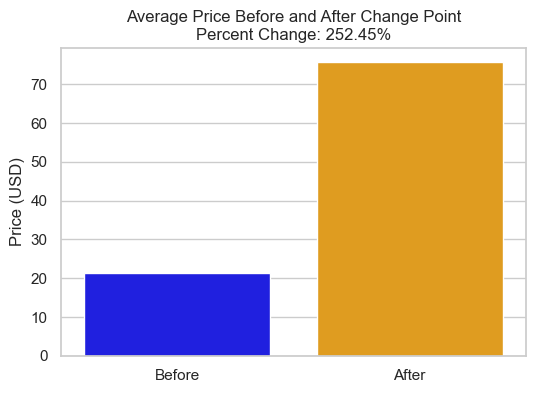

In [9]:
# Extract posterior means as scalar floats
mu1_mean = float(trace.posterior['mu1'].mean().values)
mu2_mean = float(trace.posterior['mu2'].mean().values)

# Percent change
percent_change = ((mu2_mean - mu1_mean) / mu1_mean) * 100

print(f"Estimated Change Point Date: {data['Date'].iloc[tau_mean]}")
print(f"Before Mean Price: ${mu1_mean:.2f}")
print(f"After Mean Price: ${mu2_mean:.2f}")
print(f"Percent Change: {percent_change:.2f}%")

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Before', 'After'], y=[mu1_mean, mu2_mean], palette=['blue','orange'])
plt.title(f'Average Price Before and After Change Point\nPercent Change: {percent_change:.2f}%')
plt.ylabel('Price (USD)')
plt.show()

**Event Overlay**

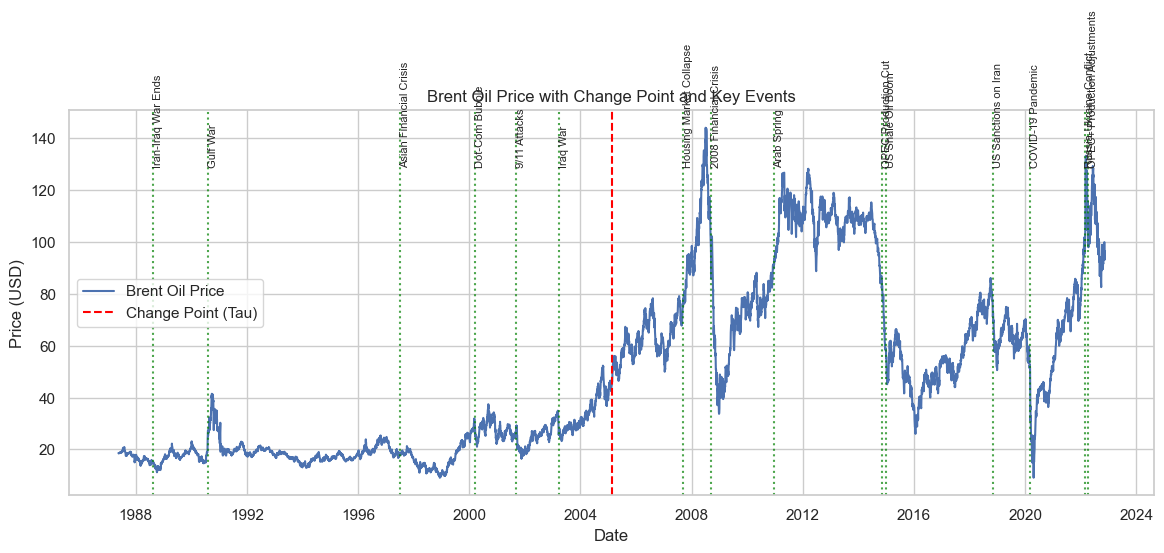

In [11]:
events = pd.read_csv(r"C:\Users\bezis\Downloads\Brent-Oil-Insights\data\events.csv")  # columns: Date, Event
events['Date'] = pd.to_datetime(events['Date'])

plt.figure(figsize=(14,5))
plt.plot(data['Date'], data['Price'], label='Brent Oil Price')

# Plot change point
plt.axvline(data['Date'].iloc[tau_mean], color='red', linestyle='--', label='Change Point (Tau)')

# Plot events
for idx, row in events.iterrows():
    plt.axvline(row['Date'], color='green', linestyle=':', alpha=0.7)
    plt.text(row['Date'], data['Price'].max()*0.9, row['Event'], rotation=90, fontsize=8)

plt.title('Brent Oil Price with Change Point and Key Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()